In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from IPython.display import Image
import zipfile as zf
import matplotlib.image as img 
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import EfficientNetB3
import random
from sklearn.metrics import confusion_matrix

seed=0
os.environ['PYTHONHASHSEED'] = str(seed)
# For working on GPUs from "TensorFlow Determinism"
os.environ["TF_DETERMINISTIC_OPS"] = str(seed)
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
path = os.getcwd()

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
new_path='/content/drive/MyDrive/AIMIA_Project'

In [ ]:
# !pip install split_folders
# import splitfolders # or import splitfolders

# input_folder = new_path
# output = new_path #where you want the split datasets saved. one will be created if it does not exist or none is set
# splitfolders.ratio(input_folder, output=output, seed=42, ratio=(.8, .1, .1)) # ratio of split are in order of train/val/test. You can change to whatever you want. For train/val sets only, you could do .75, .25 for example.

In [ ]:
train_dir = os.path.join(new_path, 'train')
validation_dir = os.path.join(new_path, 'val')
test_dir = os.path.join(new_path, 'test')

BATCH_SIZE = 32
IMG_SIZE = (256, 256)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            label_mode="categorical",
                                                            seed = 1,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 label_mode="categorical",
                                                                 seed = 1,
                                                                 image_size=IMG_SIZE)
test_dataset = test_datagen.flow_from_directory(test_dir,
                                                shuffle=False,
                                                batch_size=BATCH_SIZE,
                                                class_mode="categorical",
                                                seed = 1,
                                                target_size=IMG_SIZE)

Found 2450 files belonging to 3 classes.
Found 305 files belonging to 3 classes.
Found 309 images belonging to 3 classes.


In [ ]:
model = tf.keras.Sequential()
effnetb3 = EfficientNetB3(include_top=False,weights='imagenet',input_shape=(256,256,3),pooling='max')
fine_tune_at = 300

# Freeze all the layers before the `fine_tune_at` layer
for layer in effnetb3.layers[:fine_tune_at]:
  layer.trainable = False
model.add(effnetb3)
model.add(tf.keras.layers.Dense(3,activation='softmax'))
model.summary()


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 dense_13 (Dense)            (None, 3)                 4611      
                                                                 
Total params: 10,788,146
Trainable params: 7,806,991
Non-trainable params: 2,981,155
_________________________________________________________________


In [ ]:
optimizer = tf.keras.optimizers.Adam(name='Adam')
ACCURACY_THRESHOLD = 0.98
class myCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('accuracy') > ACCURACY_THRESHOLD):   
            print("\nReached %2.2f%% accuracy, so stopping training!!" %(ACCURACY_THRESHOLD*100))   
            self.model.stop_training = True
            
callbacks = myCallback()
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(x=train_dataset,epochs=40,validation_data=validation_dataset,shuffle=False,callbacks=callbacks)

Epoch 1/40
77/77 [==============================] - 45s 391ms/step - loss: 0.9751 - accuracy: 0.8118 - val_loss: 0.4668 - val_accuracy: 0.8557
Epoch 2/40
77/77 [==============================] - 30s 363ms/step - loss: 0.1496 - accuracy: 0.9461 - val_loss: 0.2856 - val_accuracy: 0.9016
Epoch 3/40
77/77 [==============================] - 30s 362ms/step - loss: 0.0909 - accuracy: 0.9665 - val_loss: 0.4285 - val_accuracy: 0.9246
Epoch 4/40
77/77 [==============================] - 30s 357ms/step - loss: 0.0958 - accuracy: 0.9649 - val_loss: 0.3057 - val_accuracy: 0.9279
Epoch 5/40
77/77 [==============================] - 30s 364ms/step - loss: 0.0848 - accuracy: 0.9743 - val_loss: 0.2250 - val_accuracy: 0.9443
Epoch 6/40
77/77 [==============================] - 32s 382ms/step - loss: 0.0818 - accuracy: 0.9776 - val_loss: 0.2439 - val_accuracy: 0.9311
Epoch 7/40
77/77 [==============================] - 30s 359ms/step - loss: 0.0578 - accuracy: 0.9796 - val_loss: 0.3645 - val_accuracy: 0.9410

In [ ]:
Y_pred_test = model.predict(test_dataset)

10/10 [==============================] - 7s 452ms/step


In [ ]:
y_pred_test = np.array([np.argmax(i)+1 for i in Y_pred_test])
Y_test_true = test_dataset.labels
y_true_test = np.array([i+1 for i in Y_test_true])

In [ ]:
from sklearn.metrics import classification_report
print('Classification Report')
target_names = ['meningioma', 'glioma', 'pituitary tumor']
print(classification_report(y_true_test, y_pred_test, target_names=target_names))

Classification Report
                 precision    recall  f1-score   support

     meningioma       0.97      0.93      0.95        72
         glioma       0.98      0.99      0.98       144
pituitary tumor       0.98      1.00      0.99        93

       accuracy                           0.98       309
      macro avg       0.98      0.97      0.97       309
   weighted avg       0.98      0.98      0.98       309



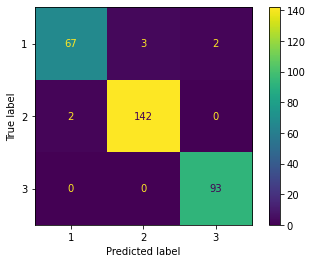

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_true_test, y_pred_test)
plt.show()

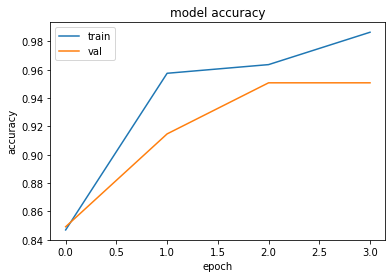

In [ ]:
# plotting the train and validation accuracy with no of epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

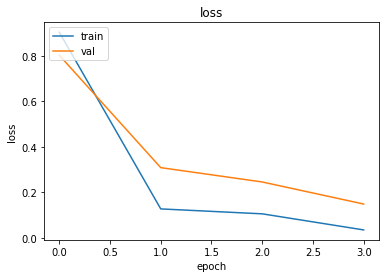

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model.save("Efficientnetb3")

In [ ]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

In [ ]:
!cp "/content/drive/MyDrive/Colab Notebooks/AIMIA_project.ipynb" ./
!jupyter nbconvert --to PDF "AIMIA_project.ipynb"